# Exploratory data analysis

In [42]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import holidays

In [2]:
TRAIN_DATA_PATH = '../data/df.csv'
RANDOM_STATE = 123

In [3]:
# freeze random state for reproducibility

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [4]:
# index feature is unique among all data, so we can skip it

data = pl.read_csv(
    TRAIN_DATA_PATH, 
    columns=['date', 'category_id', 'sku_id', 'sales_price', 'sales_quantity']
)
data.head()

date,category_id,sku_id,sales_price,sales_quantity
str,i64,i64,f64,f64
"""2016-11-25""",7,1108,457.6,1.0
"""2016-11-18""",7,2999,470.6,1.0
"""2016-11-18""",7,1428,717.6,1.0
"""2016-11-18""",7,3923,383.5,1.0
"""2016-11-18""",17,8075,18.85,2.0


### Data exploration & preprocessing

In [5]:
data = data.with_columns(
    pl.col('date').str.to_date()
)

In [6]:
# let's start with some basic statistics

data.describe()

statistic,date,category_id,sku_id,sales_price,sales_quantity
str,str,f64,f64,f64,f64
"""count""","""226486""",226486.0,226486.0,226486.0,226486.0
"""null_count""","""0""",0.0,0.0,0.0,0.0
"""mean""","""2018-12-30""",15.069594,497813.898607,109.033102,16.078857
"""std""",null,4.625731,242446.818578,151.500911,184.248121
"""min""","""2016-11-18""",7.0,1045.0,1.027,1.0
"""25%""","""2018-01-12""",17.0,398064.0,38.22,1.0
"""50%""","""2019-01-09""",17.0,550996.0,51.35,3.0
"""75%""","""2020-01-12""",17.0,702116.0,71.5,5.0
"""max""","""2020-10-31""",23.0,838924.0,2923.7,8069.0


In [21]:
data.select(
    pl.col(col).is_null().sum().alias(f'{col}_null_count')
    for col in data.columns
)

date_null_count,category_id_null_count,sku_id_null_count,sales_price_null_count,sales_quantity_null_count
u32,u32,u32,u32,u32
0,0,0,0,0


In [22]:
for col in data.columns:
    print(f'Column {col} has {len(data[col].unique())} unique values')

Column date has 1420 unique values
Column category_id has 3 unique values
Column sku_id has 1059 unique values
Column sales_price has 1373 unique values
Column sales_quantity has 979 unique values


### Firstly, let's extract some simple date features from date column

In [44]:
ukraine_holidays = holidays.Ukraine()

In [62]:
data = data.with_columns(
    pl.col('date').dt.year().alias('year'),
    pl.col('date').dt.month().alias('month'),
    pl.col('date').dt.day().alias('day'),
    pl.col('date').dt.week().alias('week'),
    pl.col('date').dt.weekday().alias('weekday'),
    pl.col('date').dt.quarter().alias('quarter'),
    pl.col('date').dt.ordinal_day().alias('day_of_year'),
    
    # add is_weekend and is_ukrainian_holiday features, because it is quite probable that on these days people would buy more
    # possibly we can merge them into one feature in the next 
    ((pl.col('date').dt.weekday() >= 5)).alias('is_weekend'),
    pl.col('date').is_in(set(ukraine_holidays)).alias('is_ukrainian_holiday')
)

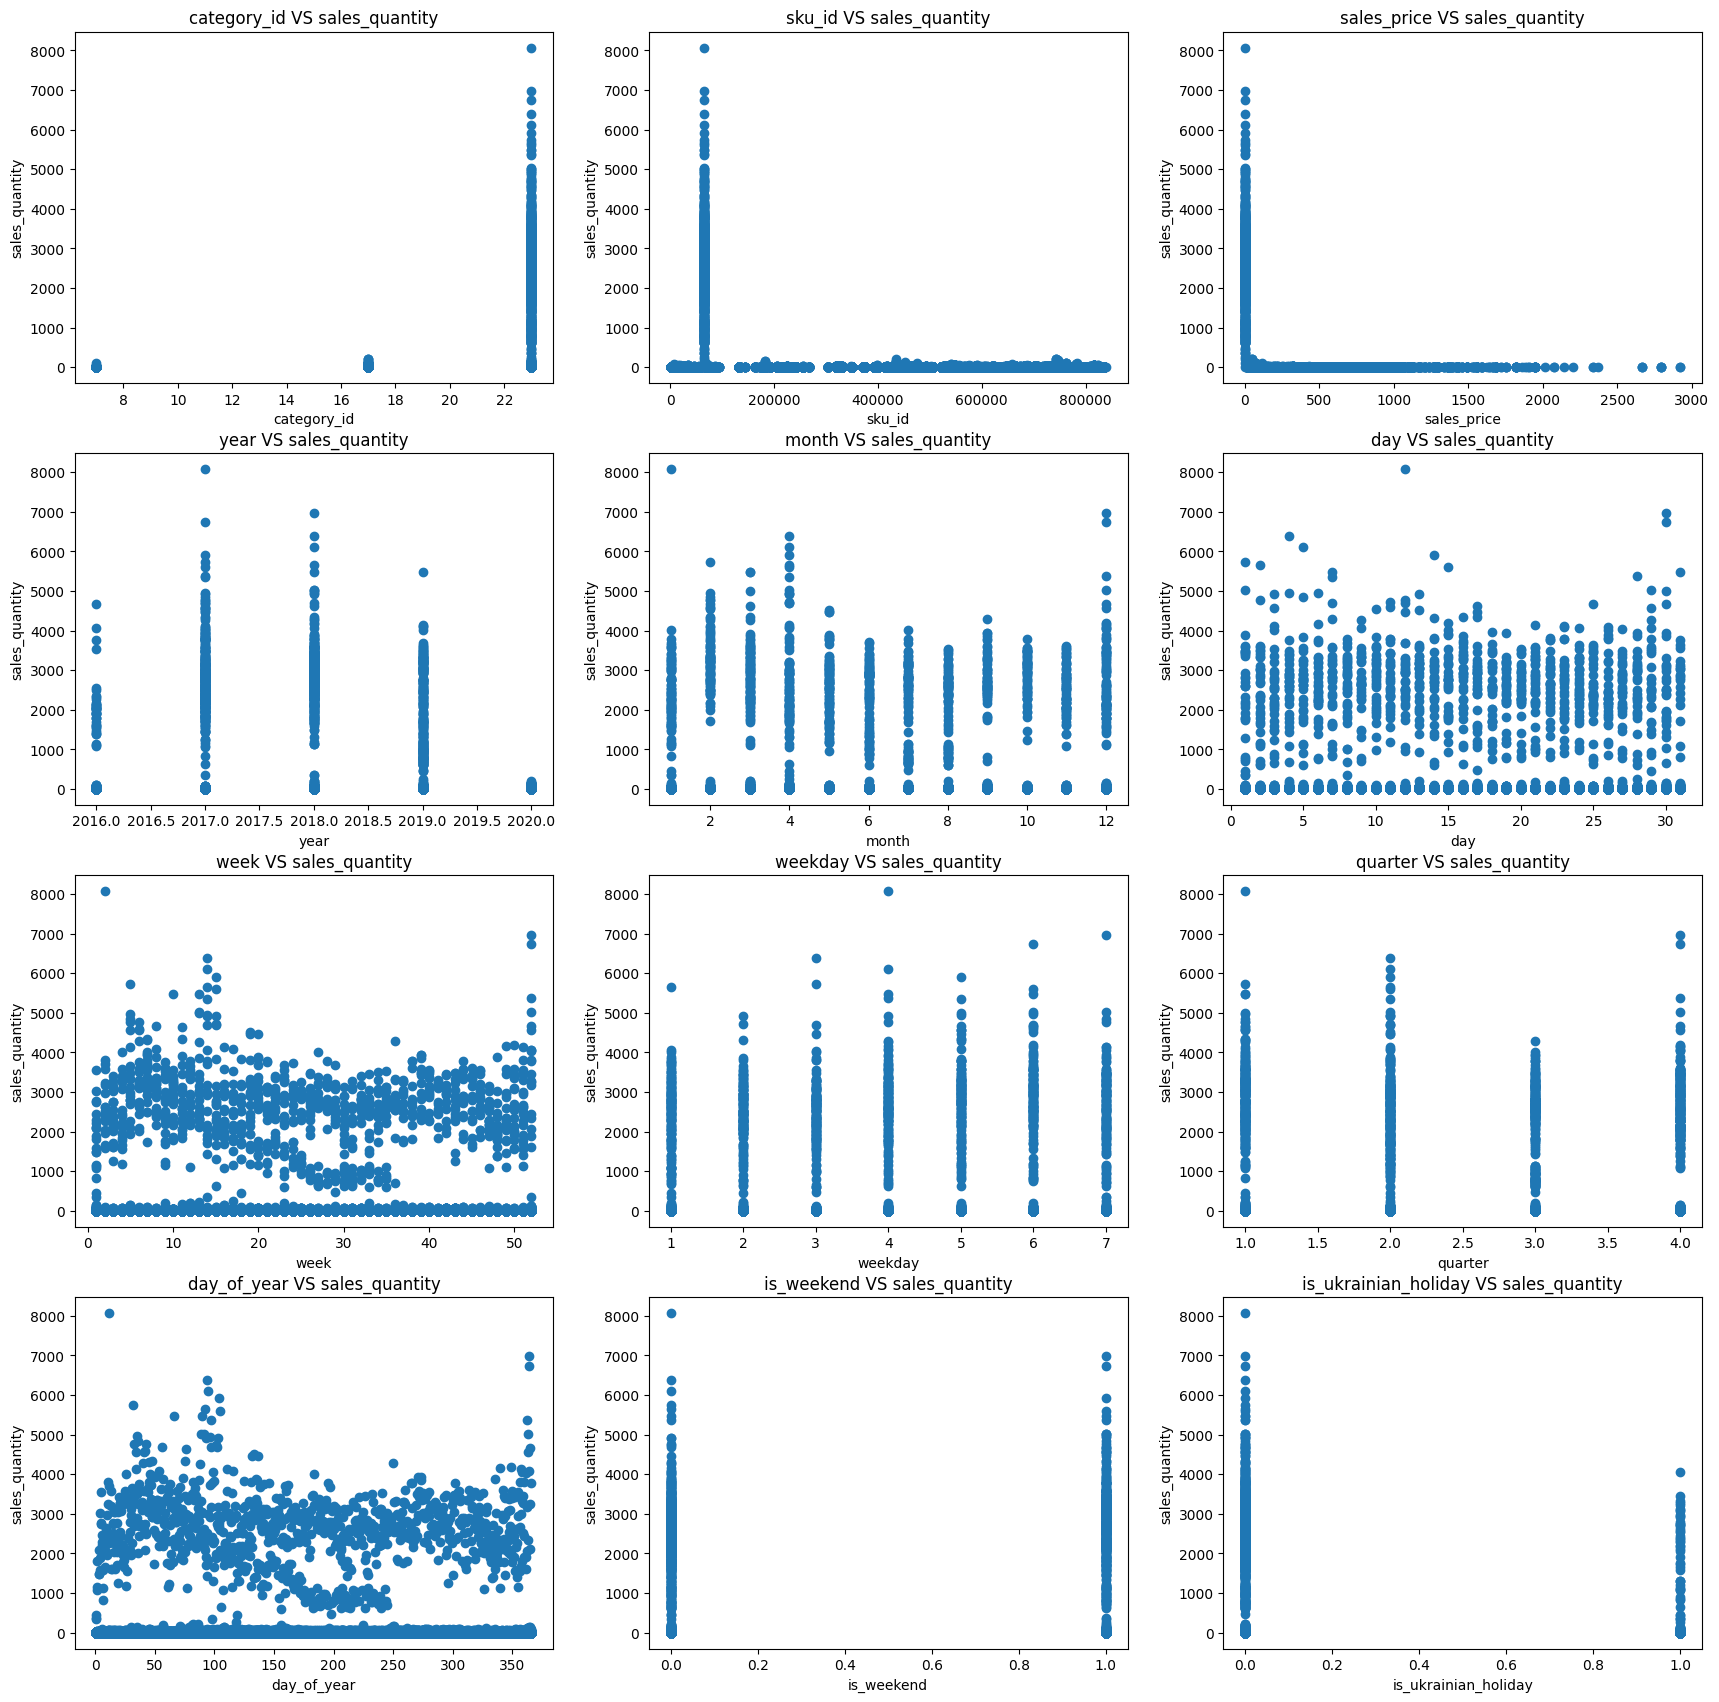

In [55]:
# let's plot all features VS target variable (sales_quantity)

plot_data = data.drop('sales_quantity', 'date')
rows = int(np.ceil(np.sqrt(len(plot_data.columns))))
cols = int(np.ceil(len(plot_data.columns) / rows))
fig, axs = plt.subplots(rows, cols, figsize=(21, 21))
for col, ax in zip(plot_data.columns, axs.flatten()):
    ax.scatter(plot_data[col], data['sales_quantity'])
    ax.set_xlabel(col)
    ax.set_ylabel('sales_quantity')
    ax.set_title(f'{col} VS sales_quantity')
plt.show()

- from the above plot we can see that on holidays people usually buy less than on weekdays
- there is an interesting relashionship between sales_price and sales_quantity, same for sku_id and sales_quantity
- category “23” is bought much more than other categories (TODO: needs to be validated, see fraction of categories in dataset)

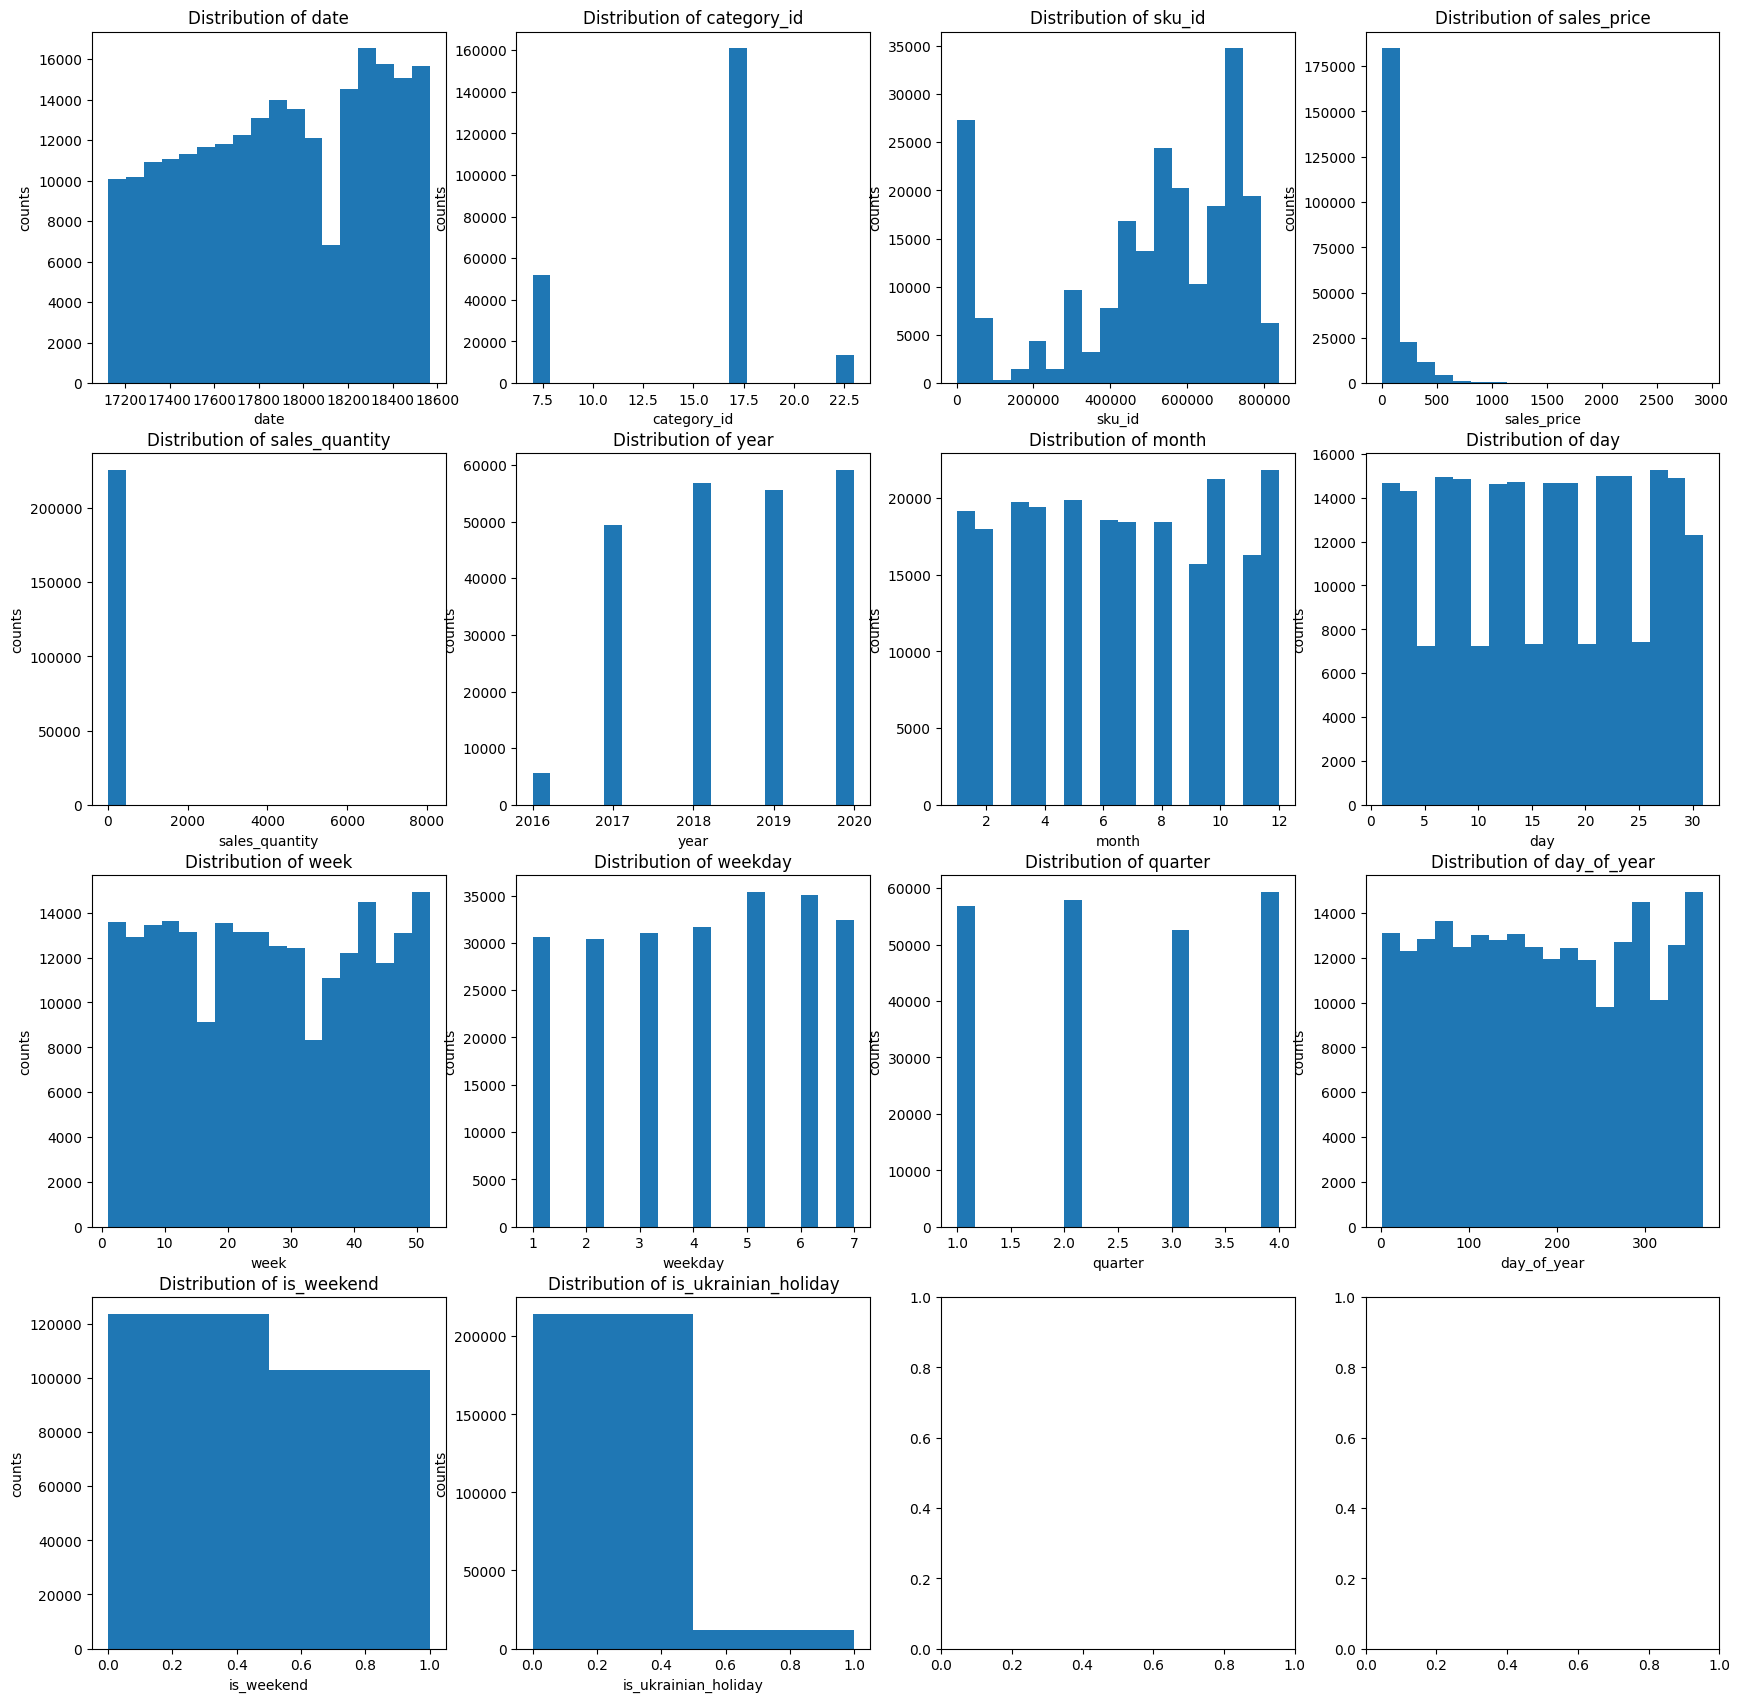

In [61]:
# let's also see each column distribution closely

rows = int(np.ceil(np.sqrt(len(data.columns))))
cols = int(np.ceil(len(data.columns) / rows))
fig, axs = plt.subplots(rows, cols, figsize=(21, 21))
for col, ax in zip(data.columns, axs.flatten()):
    tdata = data[col].cast(pl.Int64)
    is_boolean = len(tdata.unique()) == 2
    ax.hist(tdata, bins= 2 if is_boolean else int(np.log2(len(tdata))+1))
    ax.set_xlabel(col)
    ax.set_ylabel('counts')
    ax.set_title(f'Distribution of {col}')
plt.show()

- from the above graph and category_id distribution, we can see that fraction of "23" category is not high, so we can conclude that **category “23” is bought much more than other categories**

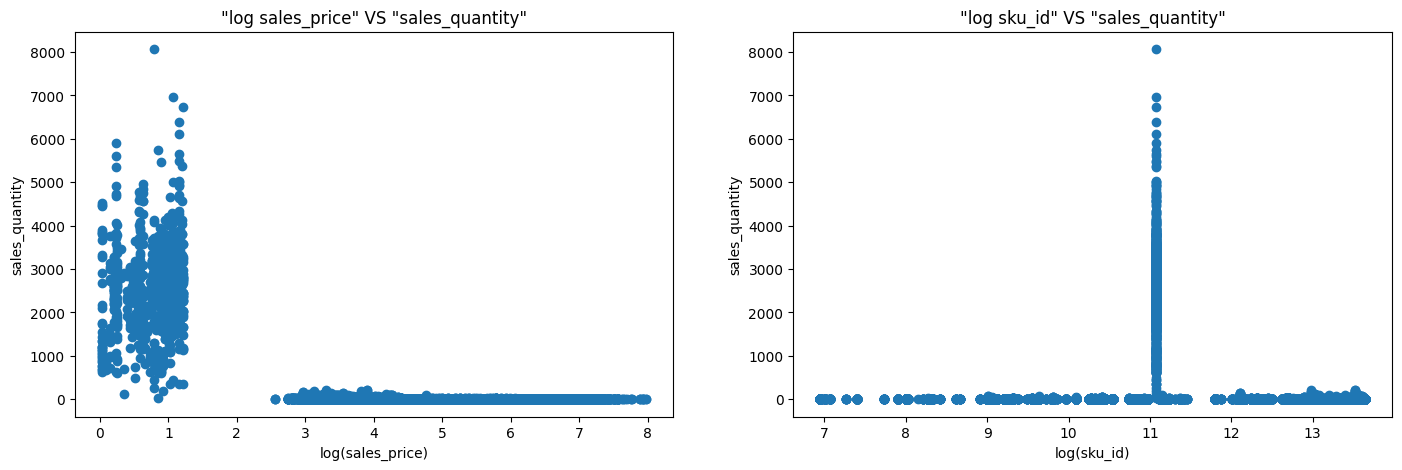

In [19]:
# from the above scatter plots we can also see that there is interesting relationship between sales_price and sales_quantity
# the same is also true for sku_id and sales_quantity
# let's try to plot log-scaled features to see whether there is more clear correlation

fig, axs = plt.subplots(1, 2, figsize=(17, 5))
axs[0].scatter(np.log(data['sales_price']), data['sales_quantity'])
axs[1].scatter(np.log(data['sku_id']), data['sales_quantity'])

axs[0].set_title('"log sales_price" VS "sales_quantity"')
axs[0].set_xlabel('log(sales_price)')
axs[0].set_ylabel('sales_quantity')
axs[1].set_title('"log sku_id" VS "sales_quantity"')
axs[1].set_xlabel('log(sku_id)')
axs[1].set_ylabel('sales_quantity')

plt.show()

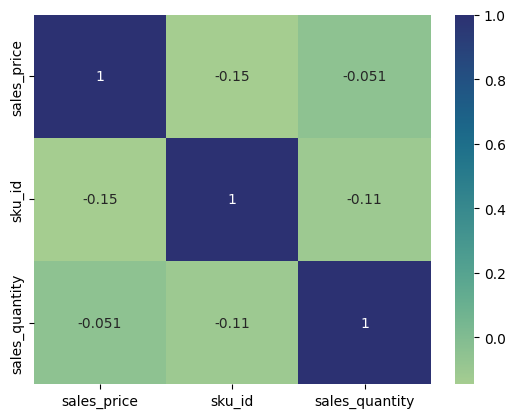

In [40]:
corr_df = data.select('sales_price', 'sku_id', 'sales_quantity').corr()
pandas_df = corr_df.to_pandas()
pandas_df.insert(0, 'index', pandas_df.columns)
pandas_df = pandas_df.set_index('index')
pandas_df.index.name = None
sns.heatmap(pandas_df, annot=True, cmap='crest')
plt.show()

- As we can see, log-scaled plot shows that sales_quantity accualy has some correlation with  

### Let's see sales_quantity dependency on date too 

#### Distributions of sales_quantity by category

In [72]:
categories = data['category_id'].unique().to_list()
categories

[7, 17, 23]

In [74]:
tdata = data['category_id'].value_counts(sort=True)
tdata.with_columns(
    (pl.col('count') / tdata['count'].sum()).alias('proportion')
)

category_id,count,proportion
i64,u32,f64
17,160797,0.709964
7,51959,0.229414
23,13730,0.060622


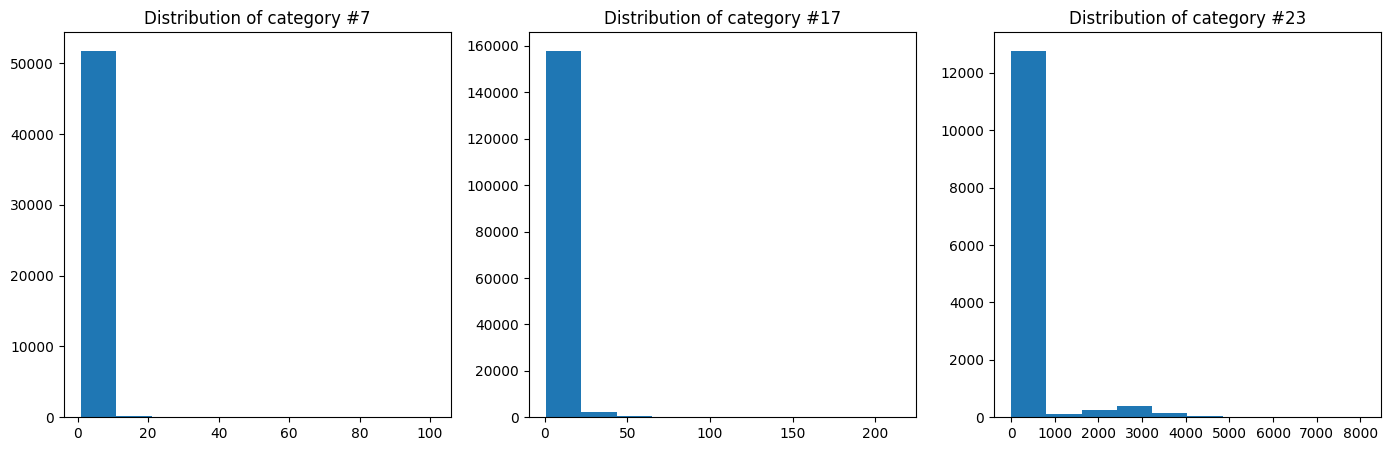

In [73]:
fig, axs = plt.subplots(ncols=len(categories), figsize=(17, 5))

for category, ax in zip(categories, axs):
    category_data = data.filter(pl.col('category_id') == category)
    ax.hist(category_data['sales_quantity'])
    ax.set_title(f'Distribution of category #{category}')

plt.show()

#### Distributions of sales_quantity by sku_id

In [74]:
skus = data['sku_id'].unique().to_list()
len(skus)

1059

In [77]:
tdata = data['sku_id'].value_counts(sort=True)
tdata = tdata.with_columns(
    (pl.col('count') / tdata['count'].sum()).alias('proportion')
)
tdata.head(n=10)

sku_id,count,proportion
i64,u32,f64
18098,1416,0.006252
33412,1414,0.006243
8220,1409,0.006221
440333,1406,0.006208
663873,1394,0.006155
493549,1392,0.006146
589894,1391,0.006142
325774,1389,0.006133
548208,1380,0.006093


In [78]:
tdata.tail(n=10)

sku_id,count,proportion
i64,u32,f64
714240,1,0.000004
687871,1,0.000004
781456,1,0.000004
480896,1,0.000004
818719,1,0.000004
824358,1,0.000004
824357,1,0.000004
838924,1,0.000004
824359,1,0.000004


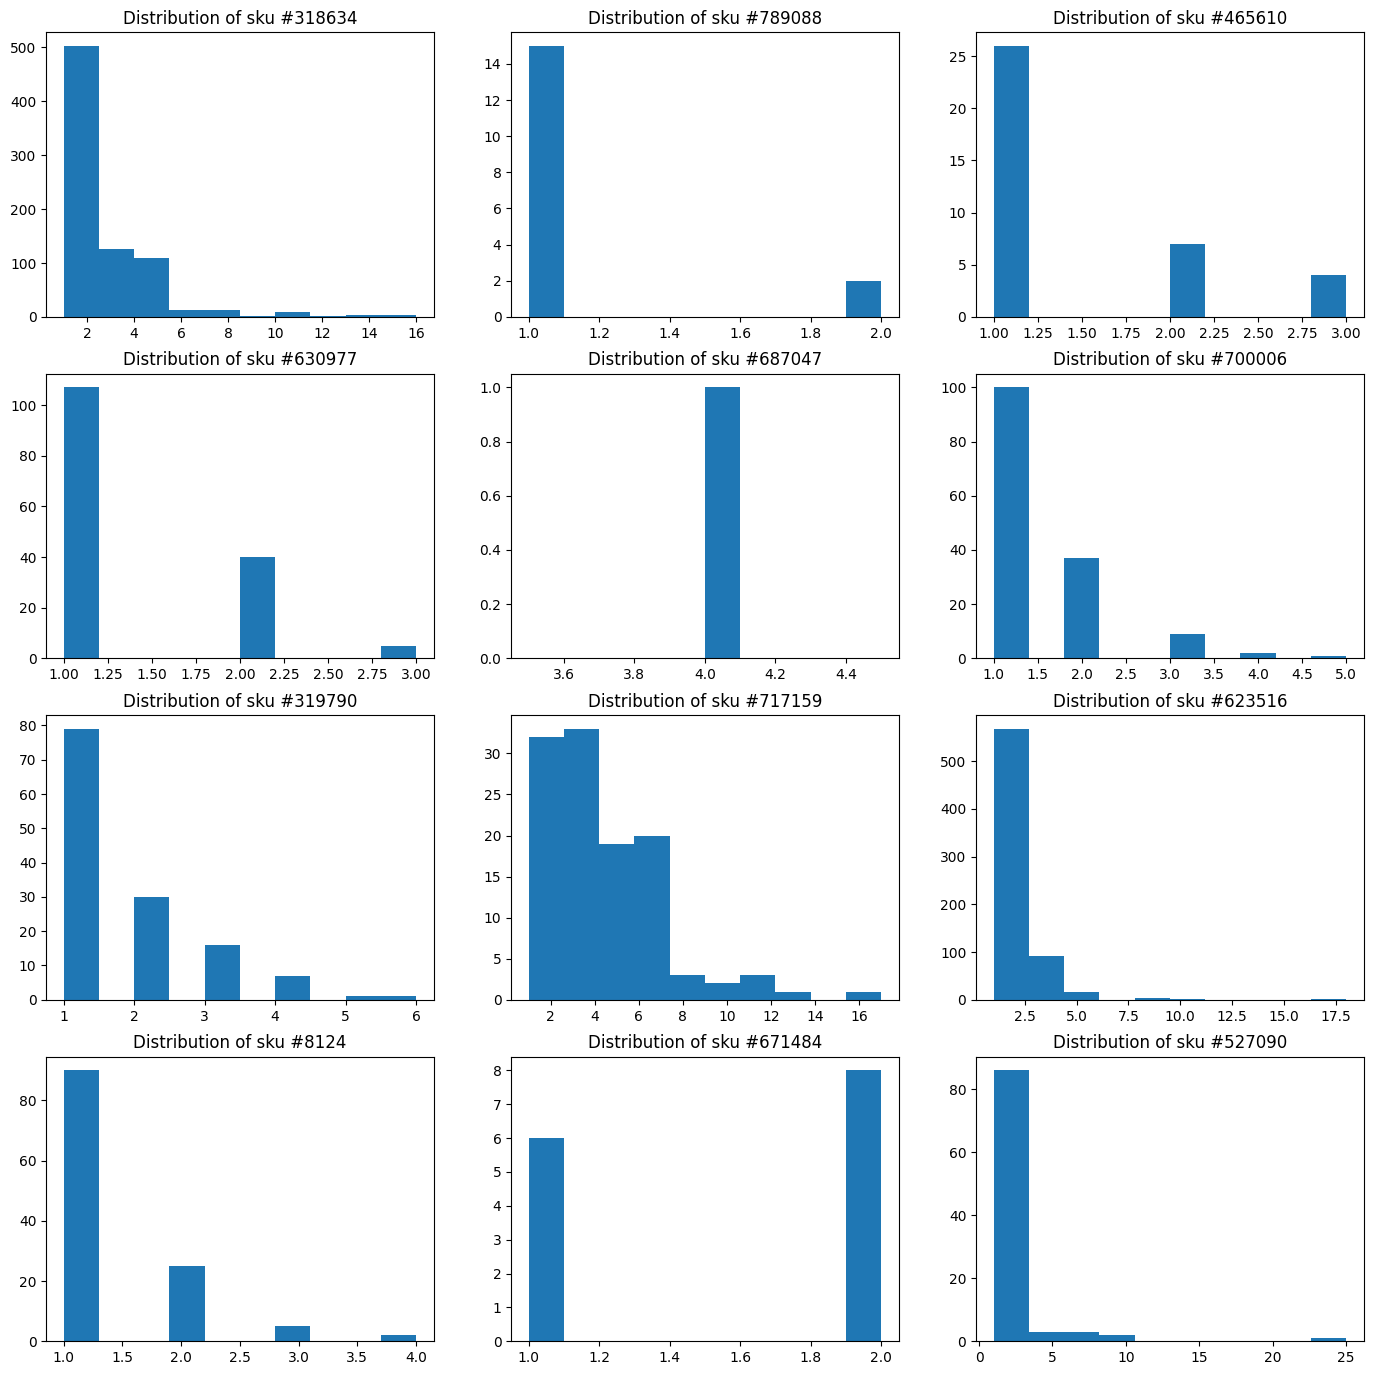

In [95]:
# let's visualize some random sales_quantity distributions by sku_id

skus = random.sample(skus, 12)

rows = int(np.ceil(np.sqrt(len(skus))))
cols = int(np.ceil(len(skus) / rows))
fig, axs = plt.subplots(rows, cols, figsize=(17, 17))

for sku, ax in zip(skus, axs.flatten()):
    sku_data = data.filter(pl.col('sku_id') == sku)
    ax.hist(sku_data['sales_quantity'], bins=10)
    ax.set_title(f'Distribution of sku #{sku}')

plt.show()

#### Distributions by dates

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

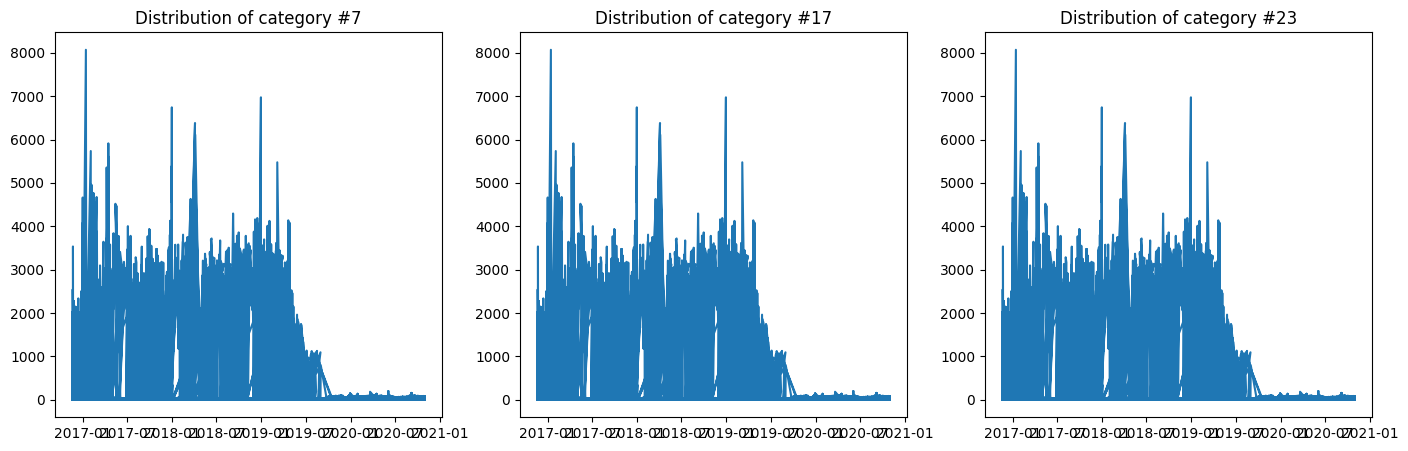

In [80]:
fig, axs = plt.subplots(ncols=len(categories), figsize=(17, 5))

for category, ax in zip(categories, axs):
    category_data = data.filter(pl.col('category_id') == category)
    ax.plot(data['date'], data['sales_quantity'])
    ax.set_title(f'Distribution of category #{category}')

plt.show()

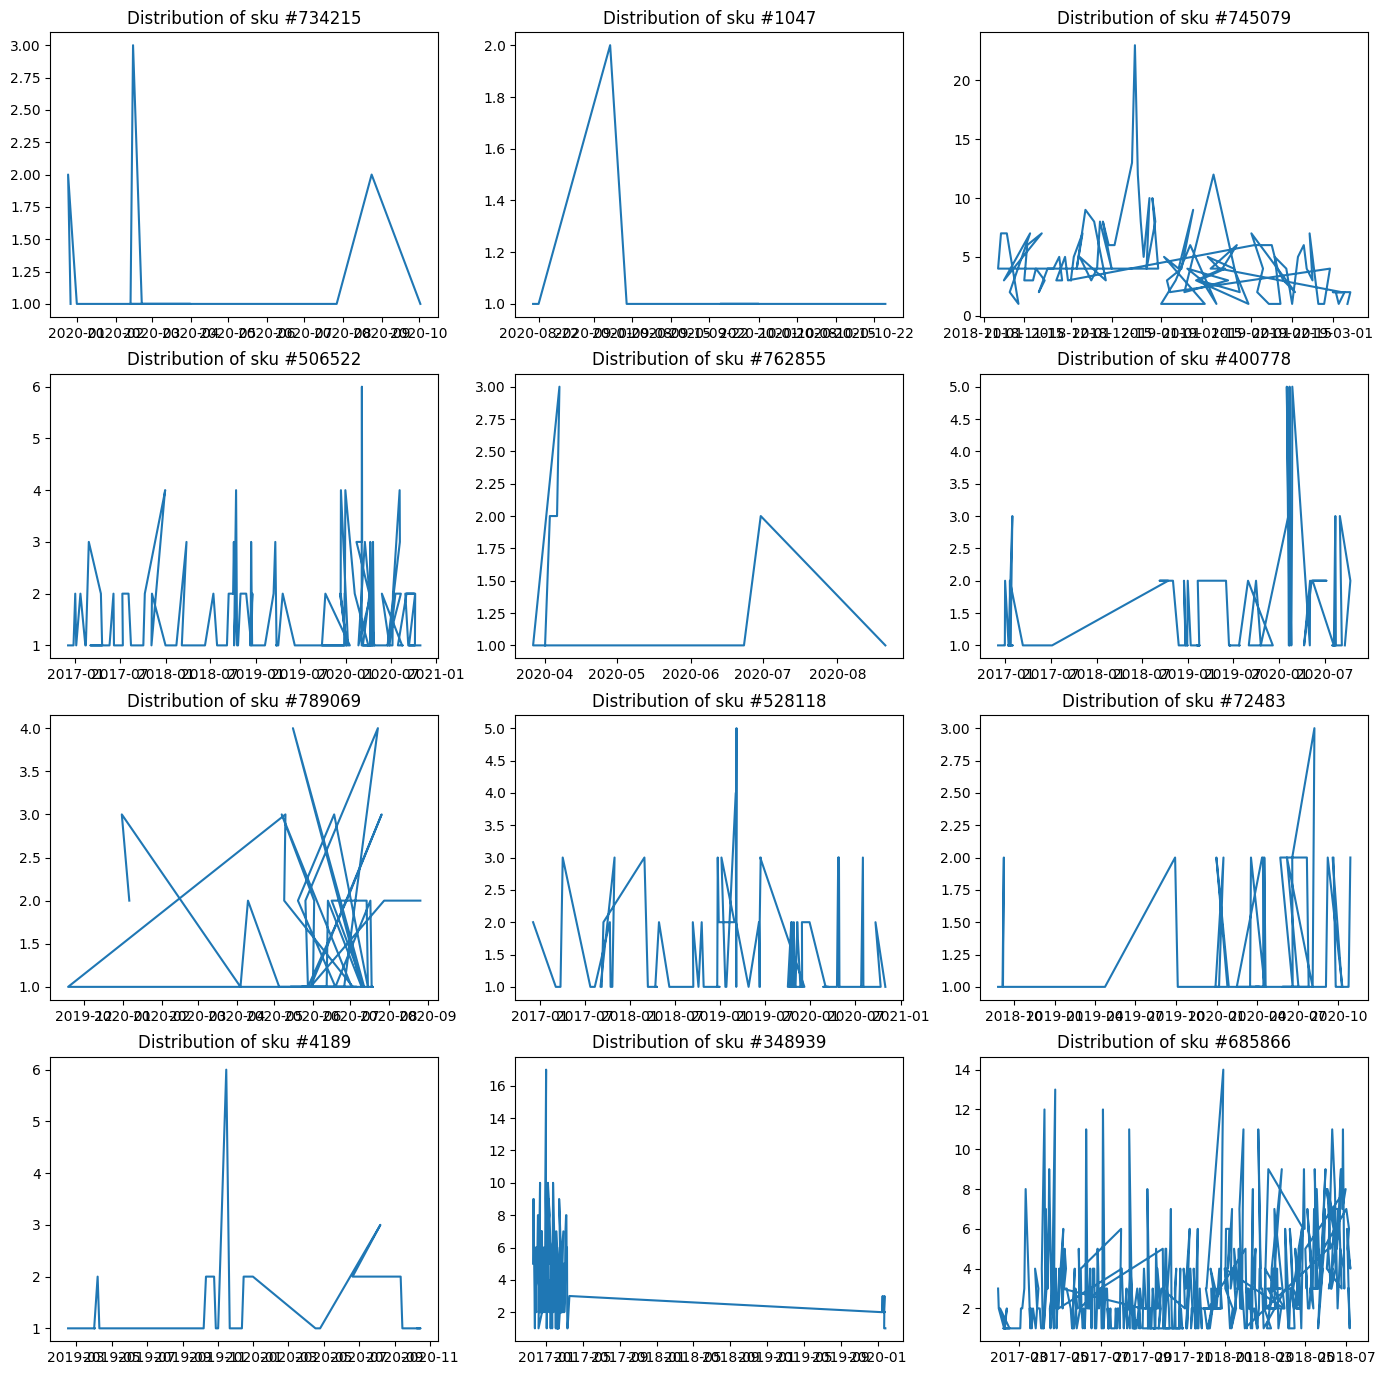

In [98]:
import random

skus = data['sku_id'].unique().to_list()
skus = random.sample(skus, 12)

rows = int(np.ceil(np.sqrt(len(skus))))
cols = int(np.ceil(len(skus) / rows))
fig, axs = plt.subplots(rows, cols, figsize=(17, 17))

for sku, ax in zip(skus, axs.flatten()):
    sku_data = data.filter(pl.col('sku_id') == sku)
    ax.plot(sku_data['date'], sku_data['sales_quantity'])
    ax.set_title(f'Distribution of sku #{sku}')

plt.show()

### Feature engineering

date,category_id,sku_id,sales_price,sales_quantity,year,month,day,week,weekday,quarter,day_of_year
date,i64,i64,f64,f64,i32,i8,i8,i8,i8,i8,i16
2016-11-25,7,1108,457.6,1.0,2016,11,25,47,5,4,330
2016-11-18,7,2999,470.6,1.0,2016,11,18,46,5,4,323
2016-11-18,7,1428,717.6,1.0,2016,11,18,46,5,4,323
2016-11-18,7,3923,383.5,1.0,2016,11,18,46,5,4,323
2016-11-18,17,8075,18.85,2.0,2016,11,18,46,5,4,323
…,…,…,…,…,…,…,…,…,…,…,…
2020-10-14,7,21442,570.7,1.0,2020,10,14,42,3,4,288
2020-10-14,7,502340,505.7,3.0,2020,10,14,42,3,4,288
2020-10-14,7,723588,401.7,3.0,2020,10,14,42,3,4,288


TODO: 
  - build features sma, ema on categories, skus
  - try to cluster sku_id into similar clusters to get more information from similar products

#### Aggregations 

In [26]:
NUM_LAGS = 5

groups = []

for id, group in data.group_by(['sku_id']):
    for lag in range(1, NUM_LAGS+1):
        group = group.with_columns(
            pl.col('sales_price').shift(lag).alias(f'sales_price_sku_lag_{lag}'),
            pl.col('sales_quantity').shift(lag).alias(f'sales_quantity_sku_lag_{lag}')
        )
    groups.append(group)


lagged = pl.concat(groups)

In [30]:
lagged.select(
    pl.col(col).is_null().sum().alias(f'{col}_nan_count')
    for col in lagged.columns
)

date_nan_count,category_id_nan_count,sku_id_nan_count,sales_price_nan_count,sales_quantity_nan_count,sales_price_sku_lag_1_nan_count,sales_quantity_sku_lag_1_nan_count,sales_price_sku_lag_2_nan_count,sales_quantity_sku_lag_2_nan_count,sales_price_sku_lag_3_nan_count,sales_quantity_sku_lag_3_nan_count,sales_price_sku_lag_4_nan_count,sales_quantity_sku_lag_4_nan_count,sales_price_sku_lag_5_nan_count,sales_quantity_sku_lag_5_nan_count
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,1059,1059,2095,2095,3109,3109,4092,4092,5053,5053


#### Time Series Indicators

We can calcualate Simple moving averages, Exponential moving averages and other similar indicators

In [31]:
lagged.head()

date,category_id,sku_id,sales_price,sales_quantity,sales_price_sku_lag_1,sales_quantity_sku_lag_1,sales_price_sku_lag_2,sales_quantity_sku_lag_2,sales_price_sku_lag_3,sales_quantity_sku_lag_3,sales_price_sku_lag_4,sales_quantity_sku_lag_4,sales_price_sku_lag_5,sales_quantity_sku_lag_5
date,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2017-05-25,17,575051,27.3,6.0,null,null,null,null,null,null,null,null,null,null
2017-05-29,17,575051,27.3,3.0,27.3,6.0,null,null,null,null,null,null,null,null
2018-12-21,7,472811,934.96,1.0,null,null,null,null,null,null,null,null,null,null
2019-02-15,7,472811,1168.7,2.0,934.96,1.0,null,null,null,null,null,null,null,null
2019-05-30,7,472811,779.987,1.0,1168.7,2.0,934.96,1.0,null,null,null,null,null,null


#### Clustering

In [33]:
cleaned = lagged.drop_nulls()

In [35]:
from sklearn.preprocessing import StandardScaler

features = cleaned.to_numpy()

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

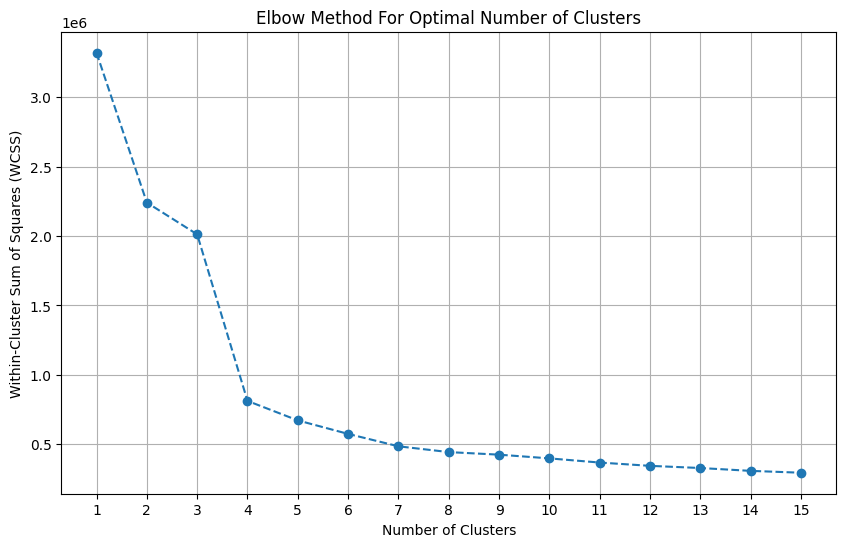

In [45]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []
max_clusters = 15
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, max_clusters + 1))
plt.grid(True)
plt.show()

In [53]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans = kmeans.fit(features_scaled)

In [54]:
clusters = kmeans.fit_predict(features_scaled)

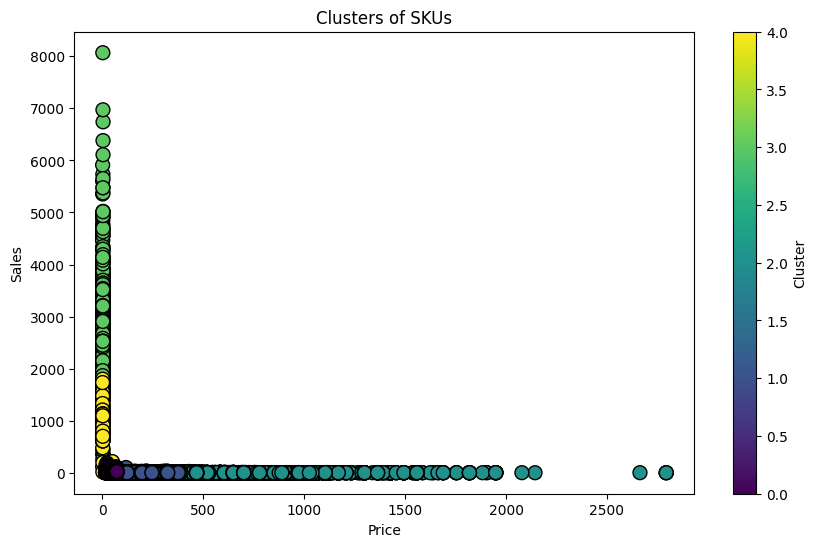

In [55]:
plt.figure(figsize=(10, 6))
plt.scatter(cleaned['sales_price'], cleaned['sales_quantity'], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=100)
plt.title('Clusters of SKUs')
plt.xlabel('Price')
plt.ylabel('Sales')
plt.colorbar(label='Cluster')
plt.show()

TODO: Add aggregations within calculated clusters

### Data augmentation

In [75]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model = RandomForestRegressor()

model.fit()